###Transfer Style using CycleGAN

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage.transform import resize
from keras.utils.vis_utils import plot_model
import imageio
import glob

###Import Dataset


In [2]:
!git clone "https://github.com/tarunmt99/cycleGAN-MRI-Scan.git"

fatal: destination path 'cycleGAN-MRI-Scan' already exists and is not an empty directory.


In [3]:
dataset_folder = "/content/cycleGAN-MRI-Scan/MRI+T1_T2+Dataset/dataset/"

In [4]:
!apt-get install rar

Reading package lists... Done
Building dependency tree       
Reading state information... Done
rar is already the newest version (2:5.5.0-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


In [5]:
!unrar x  "/content/cycleGAN-MRI-Scan/MRI+T1_T2+Dataset.RAR"  "/content/cycleGAN-MRI-Scan/MRI+T1_T2+Dataset/dataset/"


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/cycleGAN-MRI-Scan/MRI+T1_T2+Dataset.RAR


Would you like to replace the existing file /content/cycleGAN-MRI-Scan/MRI+T1_T2+Dataset/dataset/Tr1/.DS_Store
  6148 bytes, modified on 2020-11-30 11:44
with a new one
  6148 bytes, modified on 2020-11-30 11:44

[Y]es, [N]o, [A]ll, n[E]ver, [R]ename, [Q]uit A

Extracting  /content/cycleGAN-MRI-Scan/MRI+T1_T2+Dataset/dataset/Tr1/.DS_Store       0%  OK 
Extracting  /content/cycleGAN-MRI-Scan/MRI+T1_T2+Dataset/dataset/Tr1/TrainT1/Image #10.png       1%  OK 
Extracting  /content/cycleGAN-MRI-Scan/MRI+T1_T2+Dataset/dataset/Tr1/TrainT1/Image #11.png       2%  OK 
Extracting  /content/cycleGAN-MRI-Scan/MRI+T1_T2+Dataset/dataset/Tr1/TrainT1/Image #12.png       3%  OK 
Extracting  /content/cycleGAN-MRI-Scan/MRI+T1_T2+Dataset/dataset/Tr1/TrainT1/Image #13.png       4%  OK 
Extracting  /content/cycleGAN-MRI-Scan/MRI+T

In [6]:
T1_train_folder = dataset_folder+"Tr1"
T2_train_folder = dataset_folder + "Tr2"

In [7]:
BATCH_SIZE = 128
image_height = 256  
image_width = 256

### Data Loading and Visualization
1. Data Loading
2. Data Visualization

In [8]:
T1_images = tf.keras.preprocessing.image_dataset_from_directory(
  T1_train_folder,
  seed=100,color_mode= "grayscale",
  image_size=(image_height, image_width),
  batch_size=BATCH_SIZE)
T1_images

Found 43 files belonging to 1 classes.


<BatchDataset shapes: ((None, 256, 256, 1), (None,)), types: (tf.float32, tf.int32)>

In [9]:
T2_images = tf.keras.preprocessing.image_dataset_from_directory(
  T1_train_folder,
  seed=100,color_mode= "grayscale",
  image_size=(image_height, image_width),
  batch_size=BATCH_SIZE)
T2_images

Found 43 files belonging to 1 classes.


<BatchDataset shapes: ((None, 256, 256, 1), (None,)), types: (tf.float32, tf.int32)>

### Data Preprocessing
1.   Data Resizing
2.   Data Reshaping
3.   Batch and Shuffle Data

In [10]:
from tensorflow.keras import layers

data_augmentation = layers.experimental.preprocessing.RandomFlip("vertical")
T1_images_augumented = T1_images.map(lambda x, y: (data_augmentation(x), y))
T2_images_augumented = T2_images.map(lambda x, y: (data_augmentation(x), y))

In [11]:
resize_layer = layers.experimental.preprocessing.Resizing(256, 256, interpolation='bilinear')
T1_images_reshaped = T1_images_augumented.map(lambda x, y: (resize_layer(x), y))
T2_images_reshaped = T2_images_augumented.map(lambda x, y: (resize_layer(x), y))

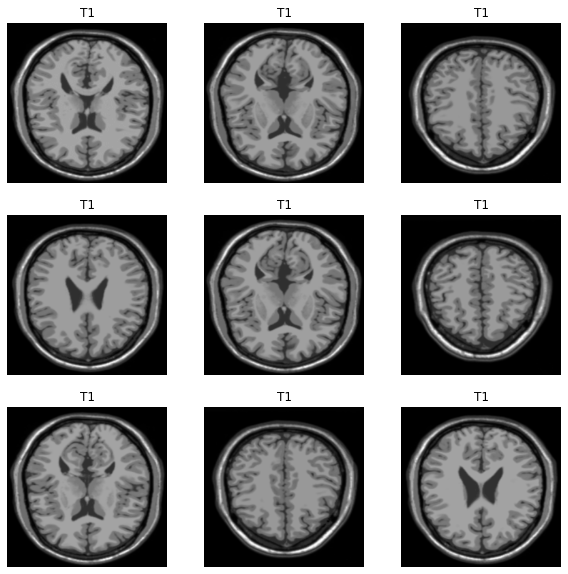

In [12]:
plt.figure(figsize=(10, 10))
for images, labels in T1_images.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')
    plt.title("T1")
    plt.axis("off")

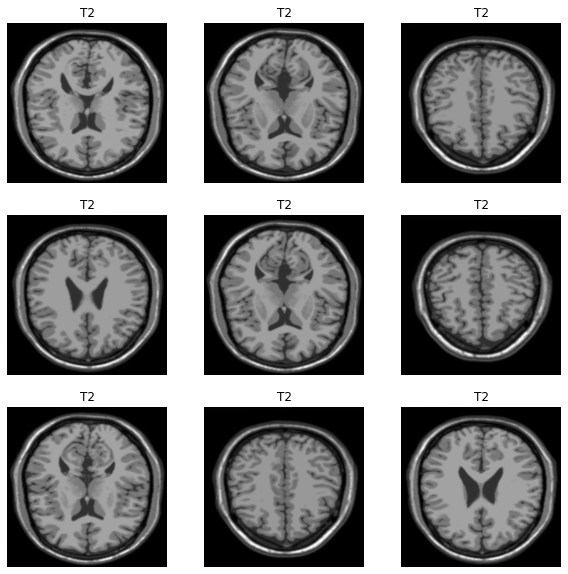

In [13]:
plt.figure(figsize=(10, 10))
for images, labels in T2_images.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')
    plt.title("T2")
    plt.axis("off")

In [14]:
def normalize_image(image):
    image =  tf.cast(image, tf.float32)
    image= (image / 127.5) - 1 
    return image

### Model Building
1. Instance Normalization
2. Downsampling, Upsampling and Unet
3. Generator Building using Unet
4. Discriminator Building

#### Instance Normalization
Instance Normalization are specially used with Style Transfer, where Separate Normalization is performed for each sample we perform channelwise Normalization.

In [15]:
class InstanceNormalization(tf.keras.layers.Layer):
    # Initialization of Objects
    def __init__(self, epsilon=1e-5):
        # calling parent's init
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon
    
    def build(self, input_shape):
        self.scale = self.add_weight(
            name='scale',
            shape=input_shape[-1:],
            initializer=tf.random_normal_initializer(1., 0.02),
            trainable=True)
        self.offset = self.add_weight(
            name='offset',
            shape=input_shape[-1:],
            initializer='zeros',
            trainable=True)
    
    def call(self, x):
        # Compute Mean and Variance, Axes=[1,2] ensures Instance Normalization
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (x - mean) * inv
        return self.scale * normalized + self.offset

#### Downsampling
Downsampling is performed using the Convolution, leading to reduce in dimensions.

In [16]:
def downsample(filters, size, apply_norm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    # Add Conv2d layer
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                      kernel_initializer=initializer, use_bias=False))
    # Add Normalization layer
    if apply_norm:
        result.add(InstanceNormalization())
    # Add Leaky Relu Activation
    result.add(tf.keras.layers.LeakyReLU())
    return result

#### Upsampling
Upsampling is a result of Transposed Convolution, where dimension of image are increased.

In [17]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    # Add Transposed Conv2d layer
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                               kernel_initializer=initializer, use_bias=False))
    # Add Normalization Layer
    result.add(InstanceNormalization())
    # Conditionally add Dropout layer
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    # Add Relu Activation Layer
    result.add(tf.keras.layers.ReLU())
    return result

#### Unets
Unets takes Image as an input and translate it into another Image. <p>
To do this they first use Downsampling on Input Image to learn the latent characteristics of Input Image and then use Upsampling to use this knowledge to Translate it into another Image. <p>
Let's understand it through the below image.

In [18]:

def unet_generator():
    down_stack = [
        downsample(64, 4, False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 8, 128)
        downsample(128, 4), # (bs, 32, 4, 128)
        downsample(128, 4), # (bs, 16, 2, 128)
        downsample(128, 4),
        downsample(256, 4),
        downsample(256, 4),
        downsample(256, 4) # (bs, 1, 1, 256)
    ]
    up_stack = [
        upsample(256,4,True),
        upsample(256,4,True),
         upsample(256,4,True),

        upsample(128, 4, True), # (bs, 2, 2, 256)
        upsample(128, 4, True),
        upsample(128, 4, True), # (bs, 4, 4, 256)
        upsample(128, 4), # (bs, 8, 8, 256)
        upsample(64, 4) # (bs, 16, 16, 128)
    ]
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(1, 4, strides=2, padding='same', kernel_initializer=initializer,
                                           activation='tanh') # (bs, 32, 32, 1)
    concat = tf.keras.layers.Concatenate()
    inputs = tf.keras.layers.Input(shape=[image_height, image_width, 1])
    x = inputs
    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    
    skips = reversed(skips[:-1])
    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concat([x, skip])
    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

In [19]:
generator_g = unet_generator()
generator_f = unet_generator()

In [20]:
generator_g.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 128, 128, 64  1024        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 sequential_1 (Sequential)      (None, 64, 64, 128)  131328      ['sequential[0][0]']             
                                                                                              

#### Discriminator
Define Discriminator architecture



In [21]:
# Discriminators only contain Convolutional Layers and no Transposed Convolution is not used 
def discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    # add input layer of size (32, 32, 1)
    inp = tf.keras.layers.Input(shape=[image_height, image_width, 1], name='input_image')
    x = inp
    
    # add downsampling step here
    down1 = downsample(64, 4, False)(x) # (bs, 16, 16, 64)
    down2 = downsample(128, 4)(down1) # (bs, 8, 8, 128)
    down3 = downsample(128, 4)(down2)
    down4 = downsample(256, 4)(down3)
   
    # add a padding layer here
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down4) # (bs, 10, 10, 128)
    
    # implement a concrete downsampling layer here
    conv = tf.keras.layers.Conv2D(256, 4, strides=1, kernel_initializer=initializer,
                                  use_bias=False)(zero_pad1) # (bs, 7, 7, 256)
    norm1 = InstanceNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(norm1)
    
    # apply zero padding layer
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 9, 9, 256)
    
    # add a last pure 2D Convolution layer
    last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2) # (bs, 6, 6, 1)
    return tf.keras.Model(inputs=inp, outputs=last)

In [22]:
discriminator_x = discriminator()
discriminator_y = discriminator()

In [23]:
discriminator_x.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 256, 256, 1)]     0         
                                                                 
 sequential_32 (Sequential)  (None, 128, 128, 64)      1024      
                                                                 
 sequential_33 (Sequential)  (None, 64, 64, 128)       131328    
                                                                 
 sequential_34 (Sequential)  (None, 32, 32, 128)       262400    
                                                                 
 sequential_35 (Sequential)  (None, 16, 16, 256)       524800    
                                                                 
 zero_padding2d (ZeroPadding  (None, 18, 18, 256)      0         
 2D)                                                             
                                                           

In [24]:
TR1_data, _ = next(iter(T1_images_reshaped))
TR2_data, _ = next(iter(T2_images_reshaped))

In [25]:
tr1_sample_data = T1_images_reshaped.shuffle(2)
tr2_sample_data = T2_images_reshaped.shuffle(2)

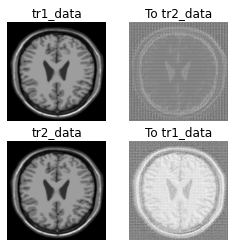

In [26]:
to_TR2_data = generator_g(TR1_data)
to_TR1_data = generator_f(TR2_data)
plt.figure(figsize=(4, 4))

imgs = [TR1_data, to_TR2_data, TR2_data, to_TR1_data]
title = ['tr1_data', 'To tr2_data', 'tr2_data', 'To tr1_data']

for i in range(len(imgs)): 
    plt.subplot(2, 2, i+1)
    plt.title(title[i])
    plt.imshow(imgs[i][0].numpy()[:, :, 0], cmap='gray')
    plt.axis('off')
plt.show()

#### Declare Loss as Binary Cross Entropy
Since Our Discriminator is a classifier

In [27]:

loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

LAMBDA = 10

Discriminator Loss

In [28]:
def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5 # mean of losses

In [29]:
def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

#### Cycle Loss
When we use both of Generators sequentially on a Input Image, we get Cycle Image and the L1 Loss between these two is called Cycle Loss.

In [30]:

def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

#### Cycle Loss
When we use both of Generators sequentially on a Input Image, we get Cycle Image and the L1 Loss between these two is called Cycle Loss.

In [31]:
def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return 10.0 * loss1

In [32]:
generator_g_optimizer = tf.keras.optimizers.Adam(0.0001, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(0.0001, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(0.0001, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(0.0001, beta_1=0.5)

In [33]:
EPOCHS = 20

In [34]:

checkpoint_path = './checkpoints'  
ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=EPOCHS)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

In [35]:

def generate_images(model, test_input, expected_output):
    prediction = model(test_input)
    plt.figure(figsize=(10, 10))
    display_list = [test_input[0], prediction[0], expected_output[0]]
    title = ['Input Image', 'Predicted Image', 'Expected Image']
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
       
        plt.imshow(display_list[i].numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')
        plt.axis('off')
    plt.show()

In [36]:

@tf.function
def train_step(real_x, real_y):
  
    with tf.GradientTape(persistent=True) as tape:
        
        fake_y = generator_g(real_x, training=True)  
        cycled_x = generator_f(fake_y, training=True) 
        
        fake_x =  generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True) 
        
        # same_x and same_y are used for identity loss.
        same_x = generator_f(real_x, training=True) 
        same_y = generator_g(real_y, training=True) 
        
        disc_real_x =  discriminator_x(real_x, training=True) 
        disc_real_y = discriminator_y(real_y, training=True) 
        
        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True) 
        
        # calculate the loss
        gen_g_loss = generator_loss(disc_fake_y) 
        gen_f_loss = generator_loss(disc_fake_x)
        
        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
 #calculate the total cycle loss
        
        # Total generator loss = adversarial loss + cycle loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)
        
        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x) 
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
        
    # Calculate the gradients for generator and discriminator
    generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables) 
    
    discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables) 
    discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)
    
    # Apply the gradients to the optimizer
    
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))

    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

In [37]:
for images, _ in tr1_sample_data:
    for image_y, _ in tr2_sample_data:
        print(images.shape, image_y.shape)

(43, 256, 256, 1) (43, 256, 256, 1)


In [ ]:
for epoch in range(1, EPOCHS+1):
    for image_x, _ in tr1_sample_data:
        for image_y, _ in tr2_sample_data:
            train_step(image_x, image_y)
    generate_images(generator_g, sample_tr1_data, generator_f, sample_tr2_data)
    ckpt_save_path = ckpt_manager.save()
    print('Saving checkpoint for epoch', epoch, 'at', ckpt_save_path)

### Generating a GIF for visualization of Results
Notice the Quality of results we are getting.

In [ ]:
anim_file = 'cyclegan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)